In [1]:
from pymongo import MongoClient
from pandas import DataFrame
import pandas as pd
import numpy as np 
import csv
from datetime import datetime
from pymongo import IndexModel,ASCENDING, DESCENDING

db = MongoClient('192.168.1.190',27077).analysis
# {"$gte":datetime(2018, 6, 1),"$lt":datetime(2019, 1, 1)}

In [2]:
#第一步
#筛选出2018年6月到12月实名的用户信息（）
db.ResultS1.drop()
match11 = {"$match":{"realTime":{"$regex":r"2018-07|2018-08|2018-09|2018-10|2018-11|2018-12"}}}
project11 = {"$project":{
                "mobile":1,"realTime":1,"idNum":1,"quota" : 1,"zhimaScore":"$zhima0", "tongdunScore":"$tongdun0",
                "cloudQuota":"$cloud-quota","registerTime":1, "model":1, "version":1, "familyTel":"$family.tel",
                "salesQuota":1, "channelOneCode":1, "baseQuota":1, "faceSimi":"$facesInfo.similarityNum", "jobType":"$jobInfo.jobType"
            }}
limit11 = {"$limit":1000}
piplineS1 = [match11,project11]
resultS1 = db.UserCol.aggregate(piplineS1)
db.ResultS1.insert_many(resultS1)

#创建索引和删除索引

db.ResultS1.create_indexes([IndexModel("mobile"),IndexModel("idNum")])
#db.ResultS1.drop_index("mobile_1")
print("第一步完成")


第一步完成


In [15]:
#第二步
#筛选有效订单

db.ResultS2.drop()
resultS2 = db.OrderCheckCol.find(
    {
    "orderStatus":{"$in":[61,71,93,51]},
    "stagingAmo":{"$gt": 100},
    "orderTime": {"$regex":r"2018-|2019-"}
    },
    {"userMobile":1,"orderTime":1, "stagingAmo":1, "repayInfo":1,"staginCount":1,"orderStatus":1}
)
db.ResultS2.insert_many(resultS2)
print("第二步完成")

第二步完成


In [3]:
#第三步

list_indexes1 = db.ResultS1.list_indexes()
for index1 in list_indexes1:
    print(index1)
list_indexes2 = db.ResultS2.list_indexes()
for index2 in list_indexes2:
    print(index2)


#得到2018年下半年实名认证用户中存在订单的用户
db.ResultS3.drop()

lookup31 = {"$lookup":{
               "from": "ResultS2",
               "localField": "mobile",
               "foreignField": "userMobile",
               "as": "orderDocs"
             }}
match31 = {"$match":{"orderDocs": {"$ne":[]}}}
project31 = {"$project":{
                "mobile":1,"realTime":1,"idNum":1,"quota" : 1,"zhimaScore":1, "tongdunScore":1,
                "cloudQuota":1,"registerTime":1,
                "model":1, "version":1, "familyTel":"$family.tel",
                "salesQuota":1, "channelOneCode":1, "baseQuota":1, "faceSimi":1, "jobType":1,
                "userMobile":"$orderDocs.userMobile","orderTime":"$orderDocs.orderTime", "stagingAmo":"$orderDocs.stagingAmo", 
                "staginCount":"$orderDocs.staginCount","orderStatus":"$orderDocs.orderStatus",
                "repayAmo":"$orderDocs.repayInfo.repayAmo", "repayCount":"$orderDocs.repayInfo.period",
                "orderStatus":"$orderDocs.orderStatus"
            }}
piplineS3 = [lookup31, match31,project31]
resultS3 = db.ResultS1.aggregate(piplineS3)
db.ResultS3.insert_many(resultS3)
print("第三步完成")

SON([('v', 2), ('key', SON([('_id', 1)])), ('name', '_id_'), ('ns', 'analysis.ResultS1')])
SON([('v', 2), ('key', SON([('mobile', 1)])), ('name', 'mobile_1'), ('ns', 'analysis.ResultS1')])
SON([('v', 2), ('key', SON([('idNum', 1)])), ('name', 'idNum_1'), ('ns', 'analysis.ResultS1')])
SON([('v', 2), ('key', SON([('_id', 1)])), ('name', '_id_'), ('ns', 'analysis.ResultS2')])
SON([('v', 2), ('key', SON([('userMobile', 1)])), ('name', 'userMobile_1'), ('ns', 'analysis.ResultS2')])
第三步完成


In [119]:
#第四步
#为用户打标签isRepay
db.ResultS3.update_many ({"repayAmo":[]},{"$set":{"isRepay":0}})
db.ResultS3.update_many ({"repayAmo":{"$ne":[]}},{"$set":{"isRepay":1}})
                          
#提取用订单但是没有还款信息的用户信息
db.ResultS4.drop()
resultS4 = db.ResultS3.find({"repayAmo":[]})
db.ResultS4.insert_many(resultS4)
print("第四步完成")

第四步完成


In [5]:
db.ResultS3.create_indexes([IndexModel([("mobile",ASCENDING)]),IndexModel('idNum')])
db.ResultS4.create_indexes([IndexModel([("mobile",ASCENDING)]),IndexModel('idNum')])

['mobile_1', 'idNum_1']

In [120]:
#第五步
#对比ResultS4和ResultS3的特征

import pandas
from pandas import DataFrame
import scipy.stats as stats
import matplotlib.pyplot as plt

s0 = db.ResultS1.find({})
s1 = db.ResultS3.find({})
s2 = db.ResultS4.find({})

s0 = DataFrame(s0)
s1 = DataFrame(s1)
s2 = DataFrame(s2)

print(s0.describe())
print(s1.describe())
print(s2.describe())

           baseQuota    cloudQuota      faceSimi       jobType         quota  \
count  859423.000000  1.142682e+06  1.142676e+06  1.144360e+06  1.142682e+06   
mean     2660.626326  1.716815e+03  8.895945e-01  9.399166e-01  2.417415e+03   
std       386.547518  1.487215e+03  1.072683e-01  9.878552e-01  1.231789e+03   
min         0.000000 -3.541000e+03 -1.000000e+00  0.000000e+00  0.000000e+00   
25%      2659.000000  0.000000e+00  9.028579e-01  0.000000e+00  1.059000e+03   
50%      2659.000000  1.479000e+03  9.221952e-01  0.000000e+00  3.059000e+03   
75%      2659.000000  3.059000e+03  9.342084e-01  2.000000e+00  3.079000e+03   
max      6279.000000  1.000000e+04  9.999999e-01  2.000000e+00  1.000000e+04   

         salesQuota  tongdunScore     zhimaScore  
count  1.143186e+06  1.061730e+06  888650.000000  
mean   7.746015e+03  5.941251e+01     635.141859  
std    7.053009e+03  2.889356e+01      58.470680  
min    0.000000e+00  0.000000e+00     350.000000  
25%    2.560000e+03  3.6

In [18]:
# y1_data = s2.loc[:,["salesQuota"]]

# y2_data = s1.loc[:,["salesQuota"]].sample(n=4555, axis=0)

# print(y1_data.describe())
# print(y2_data.describe())

         salesQuota
count   4555.000000
mean   14423.333260
std     6536.336547
min      750.000000
25%    10128.000000
50%    13920.000000
75%    17904.000000
max    30000.000000
         salesQuota
count   4555.000000
mean   16431.749286
std     8542.241510
min      909.000000
25%     9273.500000
50%    15243.000000
75%    23457.000000
max    30000.000000


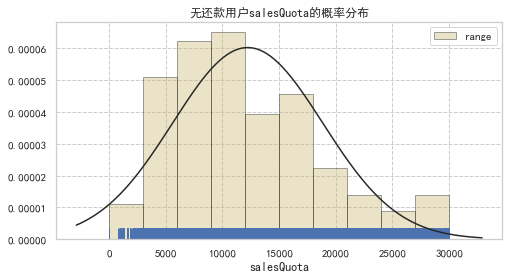

In [130]:
import seaborn as sns
from scipy.stats import stats
sns.set(context='notebook', font= 'simhei',style='whitegrid')

rs = np.random.RandomState(50)

grouped = s1.groupby('isRepay')
s = grouped.get_group(0)
s = s['salesQuota'].values

plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='salesQuota',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('无还款用户salesQuota的概率分布')
plt.show()

<class 'numpy.ndarray'>


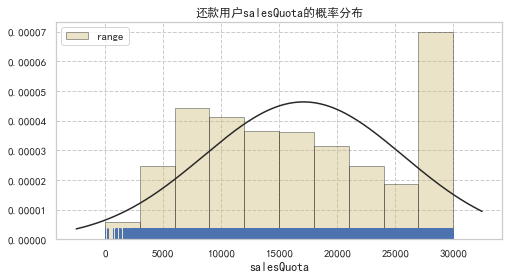

In [159]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(1)
s = s['salesQuota'].values
print(type(s))


plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='salesQuota',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('还款用户salesQuota的概率分布')
plt.show()

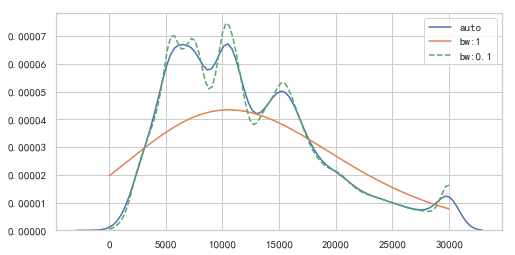

In [132]:
#核密度估计
plt.figure(figsize=(8,4))
grouped = s1.groupby('isRepay')
s = grouped.get_group(0)
s = s['salesQuota'].values

sns.kdeplot(s,label='auto')
sns.kdeplot(s,bw=1,label='bw:1',linewidth=1.5)
sns.kdeplot(s,bw=0.1,label ='bw:0.1',linestyle='--',linewidth=1.5)
plt.show()

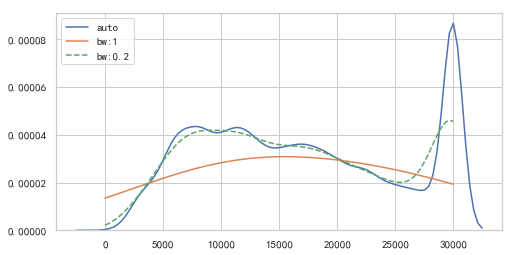

In [133]:
#核密度估计
plt.figure(figsize=(8,4))
grouped = s1.groupby('isRepay')
s = grouped.get_group(1)
s = s['salesQuota'].values

sns.kdeplot(s,label='auto')
sns.kdeplot(s,bw=1,label='bw:1',linewidth=1.5)
sns.kdeplot(s,bw=0.2,label ='bw:0.2',linestyle='--',linewidth=1.5)
plt.show()

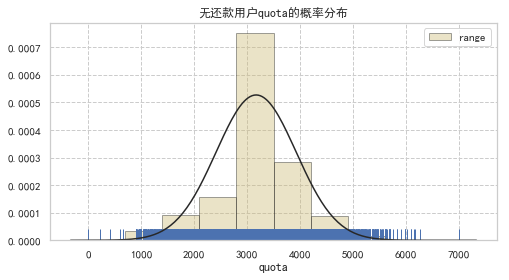

In [143]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(0)
s = s['quota'].values

plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='quota',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('无还款用户quota的概率分布')
plt.show()

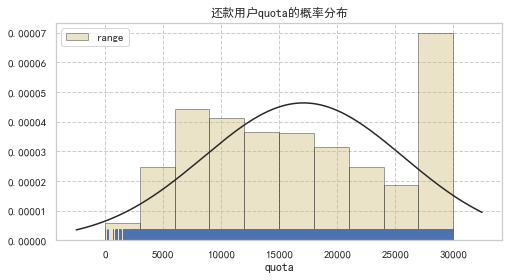

In [160]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(1)
s = s['salesQuota'].values

plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='quota',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('还款用户quota的概率分布')
plt.show()

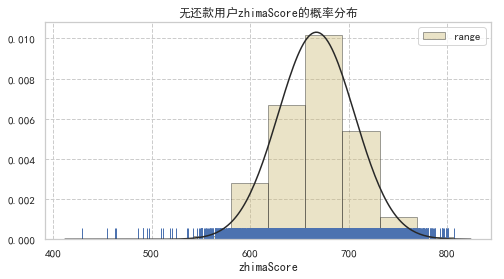

In [140]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(0)
s = s['zhimaScore'].dropna().values

plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='zhimaScore',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('无还款用户zhimaScore的概率分布')
plt.show()

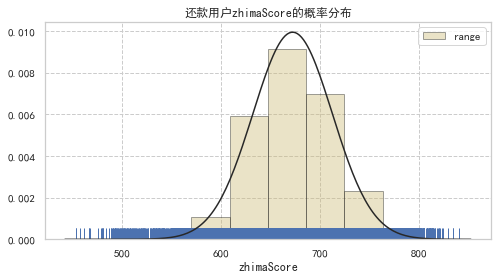

In [161]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(1)
s = s['zhimaScore'].dropna().values

plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='zhimaScore',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('还款用户zhimaScore的概率分布')
plt.show()

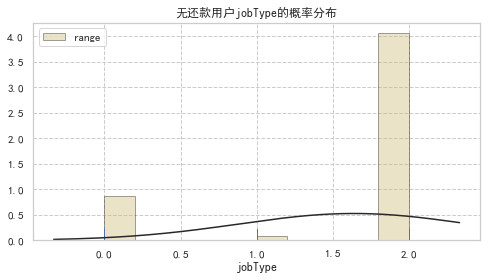

In [148]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(0)
s = s['jobType'].dropna().values


plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='jobType',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('无还款用户jobType的概率分布')
plt.show()

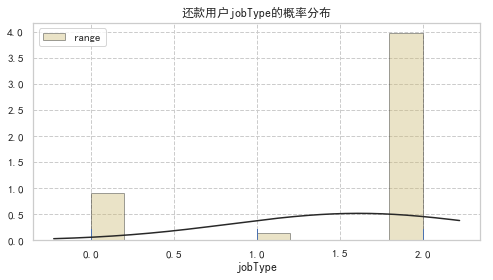

In [162]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(1)
s = s['jobType'].dropna().values

plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='jobType',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('还款用户jobType的概率分布')
plt.show()

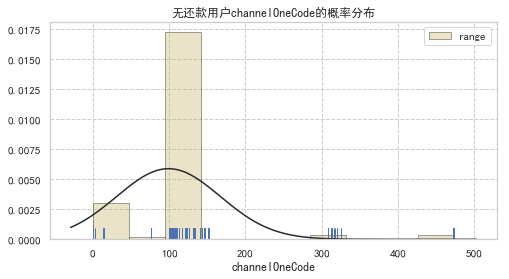

In [152]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(0)
s = s['channelOneCode'].astype('float64').dropna().values
s = s[s<1000]

plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='channelOneCode',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('无还款用户channelOneCode的概率分布')
plt.show()

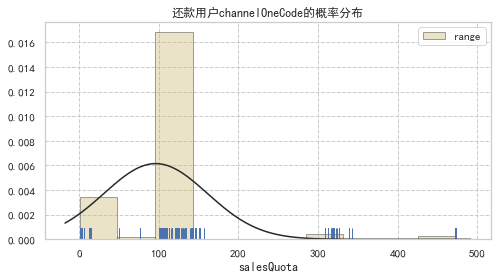

In [163]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(1)
s = s['channelOneCode'].astype('float64').dropna().values

s = s[s<1000]


plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='salesQuota',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('还款用户channelOneCode的概率分布')
plt.show()

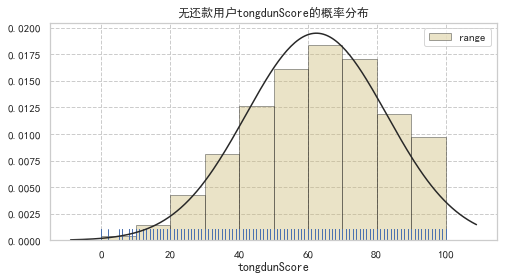

In [154]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(0)
s = s['tongdunScore'].dropna().values


plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='tongdunScore',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('无还款用户tongdunScore的概率分布')
plt.show()

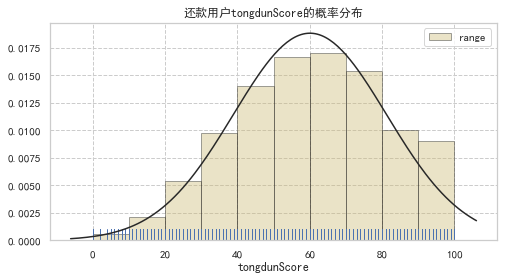

In [165]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(1)
s = s['tongdunScore'].dropna().values


plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='tongdunScore',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('还款用户tongdunScore的概率分布')
plt.show()

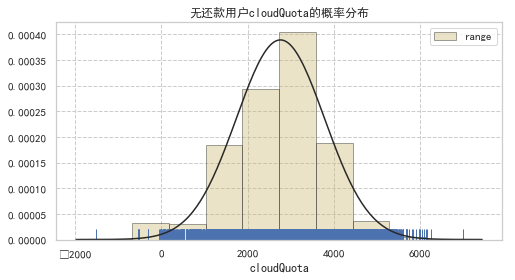

In [164]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(0)
s = s['cloudQuota'].dropna().values


plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='cloudQuota',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('无还款用户cloudQuota的概率分布')
plt.show()

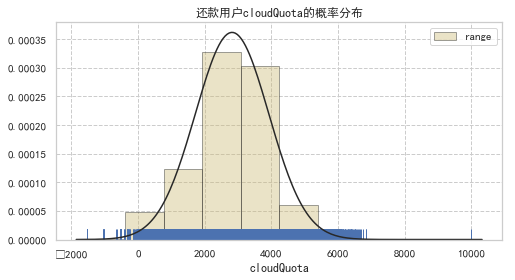

In [166]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(1)
s = s['cloudQuota'].dropna().values


plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='cloudQuota',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('还款用户cloudQuota的概率分布')
plt.show()

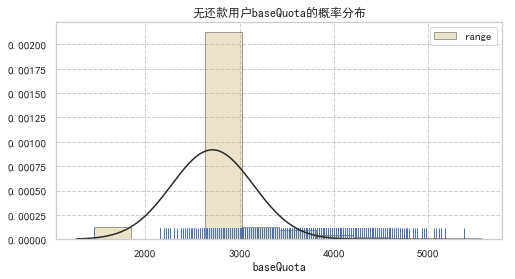

In [158]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(0)
s = s['baseQuota'].dropna().values


plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='baseQuota',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('无还款用户baseQuota的概率分布')
plt.show()

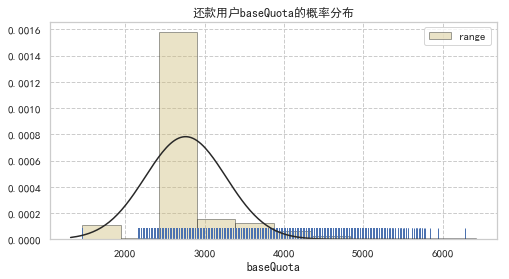

In [167]:
grouped = s1.groupby('isRepay')
s = grouped.get_group(1)
s = s['baseQuota'].dropna().values


plt.figure(figsize=(8,4))
sns.distplot(s,bins=10,hist=True, kde=False,norm_hist=False,
            rug=True, vertical=False,label='range',
            axlabel='baseQuota',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)

plt.legend()
plt.grid(linestyle='--')
plt.title('还款用户baseQuota的概率分布')
plt.show()

In [168]:
print(norm